In [51]:
import kwant

import tinyarray
import numpy as np

# For plotting
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])

In [46]:
def make_system(a=1, W=10, L=10, barrier=1.5, barrierpos=(3, 4), mu=0.4, Delta=0.1, Deltapos=4, t=1.0):
    # Start with an empty tight-binding system. On each site, there
    # are now electron and hole orbitals, so we must specify the
    # number of orbitals per site. The orbital structure is the same
    # as in the Hamiltonian.
    lat = kwant.lattice.square(norbs=2)
    syst = kwant.Builder()
    
    #### Define the scattering region. ####
    # The superconducting order parameter couples electron and hole orbitals
    # on each site, and hence enters as an onsite potential.
    # The pairing is only included beyond the point 'Deltapos' in the scattering region.
    syst[(lat(x, y) for x in range(Deltapos) for y in range(W))] = (4 * t - mu) * tau_z
    syst[(lat(x, y) for x in range(Deltapos, L) for y in range(W))] = (4 * t - mu) * tau_z + Delta * tau_x
    
    # The tunnel barrier
    syst[(lat(x, y) for x in range(barrierpos[0], barrierpos[1]) for y in range(W))] = (4 * t + barrier-mu) * tau_z
    
    # Hoppings
    syst[lat.neighbors()] = -t * tau_z
    
    #### Define the leads. ####
    # Left lead - normal, so the order parameter is zero.
    sym_left = kwant.TranslationalSymmetry((-a, 0))

    # Specify the conservation law used to treat electrons and holes separately.
    # We only do this in the left lead, where the pairing is zero.
    lead0 = kwant.Builder(sym_left, conservation_law = -tau_z, particle_hole = tau_y)
    lead0[(lat(0, j) for j in range(W))] = (4 * t - mu) * tau_z
    lead0[lat.neighbors()] = -t * tau_z
    
    # Right lead - superconducting, so the order parameter is included.
    sym_right = kwant.TranslationalSymmetry((a, 0))
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(0, j) for j in range(W))] = (4 * t - mu) * tau_z + Delta * tau_x
    lead1[lat.neighbors()] = -t * tau_z
    
    #### Attach the lead and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)
    
    return syst

In [67]:
def plot_conductance(syst, energies):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        # Conductance is N - R_ee + R_he
        data.append(smatrix.submatrix((0, 0), (0, 0)).shape[0] - 
                    smatrix.transmission((0, 0), (0, 0)) +
                    smatrix.transmission((0, 1), (0, 0)))
    
    pyplot.figure()
    pyplot.plot(energies, data)
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("conductance [e^2/h]")
    pyplot.show()

In [68]:
def check_PHS(syst):
    # Scattering matrix
    s = kwant.smatrix(syst, energy=0)
    # Electron to electron block
    s_ee = s.submatrix((0,0), (0,0))
    # Hole to hole block
    s_hh = s.submatrix((0,1), (0,1))
    print('Electron to electron block \n', 's_ee: \n', np.round(s_ee, 3))
    print('Hole to hole block \n', 's_hh: \n', np.round(s_hh[::-1, ::-1], 3))
    print('Energy Conservation \n','s_ee - s_hh^*: \n',
          np.round(s_ee - s_hh[::-1, ::-1].conj(), 3), '\n')
    # Electron to hole block
    s_he = s.submatrix((0,1), (0,0))
    # Hole to electron block
    s_eh = s.submatrix((0,0), (0,1))
    print('Electron to hole block \n', 's_he: \n', np.round(s_he, 3))
    print('Hole to electron block \n', 's_eh: \n', np.round(s_eh[::-1, ::-1], 3))
    print('Energy Conservation \n','s_he + s_eh^*: \n', np.round(s_he + s_eh[::-1, ::-1].conj(), 3))

In [69]:
def main():
    syst = make_system(W=10, mu = 0.1).finalized()
    
#    kwant.plot(syst)
    
#    syst = syst.finalized()
    
#    check_PHS(syst)
    
    plot_conductance(syst, energies = [0.002 * i for i in range(-10, 100)])
    
#    syst = make_system(W=10, mu = 0.5).finalized()
    
#    plot_conductance(syst, energies = [0.002 * i for i in range(-10, 100)])
    
#    syst = make_system(W=10, mu = 0.9).finalized()
    
#    plot_conductance(syst, energies = [0.002 * i for i in range(-10, 100)])

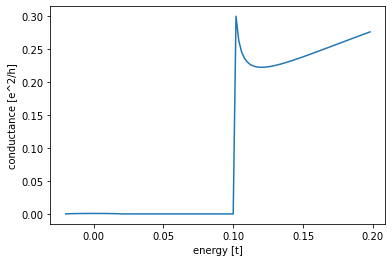

In [70]:
main()